In [14]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import root_mean_squared_error

In [38]:
base_dir = './'
fixed_setpoint_dir = os.path.join(base_dir, 'fixed_setpoint')
variable_setpoint_dir = os.path.join(base_dir, 'variable_setpoint')

In [39]:
def calculate_nrmse(df, setpoint_col, arrival_rate_col, fixed_setpoint=None):
    if fixed_setpoint == 1000:
        rmse = root_mean_squared_error([fixed_setpoint]*len(df), df[arrival_rate_col])
        nrmse = rmse / fixed_setpoint
    else:
        rmse = root_mean_squared_error(df[setpoint_col], df[arrival_rate_col])
        nrmse = rmse / (df[setpoint_col].max() - df[setpoint_col].min())
    return nrmse


def calculate_goal_rate(df, setpoint_col, arrival_rate_col):
    tolerance = 0.10 
    lower_bound = df[setpoint_col] * (1 - tolerance)
    upper_bound = df[setpoint_col] * (1 + tolerance)
    
    # Check if the arrival rate is within the bounds for each row
    hits = df[(df[arrival_rate_col] >= lower_bound) & (df[arrival_rate_col] <= upper_bound)]
    
    # Calculate hit rate
    hit_rate = len(hits) / len(df) if len(df) > 0 else 0
    return hit_rate


def process_folder(folder_path, fixed_setpoint = None):
    results = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
            
            # Calculate NRMSE and goal rate for each experiment
            nrmse = calculate_nrmse(df, 'SETPOINT', 'ARRIVAL_RATE', fixed_setpoint)
            goal_rate = calculate_goal_rate(df, 'SETPOINT', 'ARRIVAL_RATE')
            
            # Append results
            results.append({
                'file': file_name,
                'nrmse': nrmse,
                'goal_rate': goal_rate
            })
    
    return pd.DataFrame(results)


In [41]:
fixed_results = process_folder(fixed_setpoint_dir, fixed_setpoint=1000)
variable_results = process_folder(variable_setpoint_dir)

# Combine both results
all_results = pd.concat([fixed_results, variable_results], keys=['Fixed Setpoint', 'Variable Setpoint'])

# Display statistical description
stats_description = all_results.groupby(level=0).describe()

print(stats_description)

                  nrmse                                                    \
                  count      mean       std       min       25%       50%   
Fixed Setpoint     14.0  0.271738  0.083534  0.186611  0.204078  0.242910   
Variable Setpoint  14.0  0.235626  0.149427  0.148545  0.154175  0.180002   

                                      goal_rate                                \
                        75%       max     count      mean       std       min   
Fixed Setpoint     0.320680  0.455097      14.0  0.335714  0.175793  0.000000   
Variable Setpoint  0.238668  0.717914      14.0  0.346667  0.197800  0.046667   

                                                        
                     25%       50%       75%       max  
Fixed Setpoint     0.205  0.330000  0.490000  0.560000  
Variable Setpoint  0.185  0.333333  0.536667  0.613333  


In [42]:
fixed_results.sort_values(by=['nrmse'])

,file,nrmse,goal_rate
1,fuzzy8_gbellmf_mom_fixed_exp2.csv,0.186611,0.56
11,hpa_fixed_exp.csv,0.197808,0.50
5,fuzzy7_gbellmf_cod_fixed_exp2.csv,0.199280,0.46
8,fuzzy2_trimf_mom_fixed_exp2.csv,0.202801,0.52
3,fuzzy3_gaussmf_cod_fixed_exp2.csv,0.207912,0.30
6,fuzzy5_gaussmfextra_cod_fixed_exp2.csv,0.214689,0.56
12,fuzzy6_gaussmfextra_mom_fixed_exp2.csv,0.224184,0.40
10,fuzzy9_pimf_cod_fixed_exp2.csv,0.261636,0.12
13,fuzzy1_trimf_cod_fixed_exp2.csv,0.293732,0.30
7,fuzzy10_pimf_mom_fixed_exp2.csv,0.296227,0.28


In [43]:
variable_results.sort_values(by=['nrmse'])

,file,nrmse,goal_rate
1,fuzzy5_gaussmf_cod_variable_exp2.csv,0.148545,0.560000
11,hpa_variable_exp2.csv,0.150249,0.486667
5,fuzzy8_gbell_mom_variable_exp2.csv,0.150735,0.553333
3,fuzzy6_gaussmf_mom_extra_variable_exp2.csv,0.153557,0.613333
2,fuzzy4_gaussmf_mom_variable_exp2.csv,0.156031,0.600000
7,fuzzy1_trimf_cod_variable_exp2.csv,0.159434,0.460000
12,fuzzy2_trimf_mom_variable_exp2.csv,0.160286,0.353333
0,fuzzy3_gaussmf_cod_extra_variable_exp2.csv,0.199718,0.313333
8,fuzzy10_pimf_mom_variable_exp2.csv,0.226889,0.180000
13,fuzzy7_gbell_cod_variable_exp2.csv,0.228457,0.200000


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot arrival rates with dynamically added time column
def plot_arrival_rate_with_setpoint(df1, df1_label, df2, df2_label, df3, df3_label, output_pdf, arrival_rate_col='ARRIVAL_RATE', maxY = 2000):
    plt.figure(figsize=(10, 6))
    font_size = 16
    plt.plot(df1['TIME'], df1[arrival_rate_col], label=df1_label, linestyle='-', color='blue')
    plt.plot(df2['TIME'], df2[arrival_rate_col], label=df2_label, linestyle='-', color='orange')
    plt.plot(df3['TIME'], df3[arrival_rate_col], label=df3_label, linestyle='-', color='green')
    plt.plot(df3['TIME'], df1['SETPOINT'], label='Setpoint', linestyle='--', color='red')
    plt.xlabel('Time (s)', fontsize=font_size)
    plt.ylabel('Arrival Rate (msg/s)', fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.ylim(0, maxY)
    plt.legend(loc='lower right')
    plt.grid(True)
    #plt.savefig(output_pdf)
    plt.show()


In [3]:
time_step = 10

In [7]:
# Best fixed
df1 = pd.read_csv('./fixed_setpoint/exp2/fuzzy8_gbellmf_mom_fixed_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df2 = pd.read_csv('./fixed_setpoint/exp1/hpa_fixed_exp.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df3 = pd.read_csv('./fixed_setpoint/exp1/astar_fixed_exp.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])

df1['TIME'] = [time_step * (i + 1) for i in range(len(df1))]
df2['TIME'] = [time_step * (i + 1) for i in range(len(df2))]
df3['TIME'] = [time_step * (i + 1) for i in range(len(df3))]

FileNotFoundError: [Errno 2] No such file or directory: './fixed_setpoint/exp2/fuzzy8_gbellmf_mom_fixed_exp2.csv'

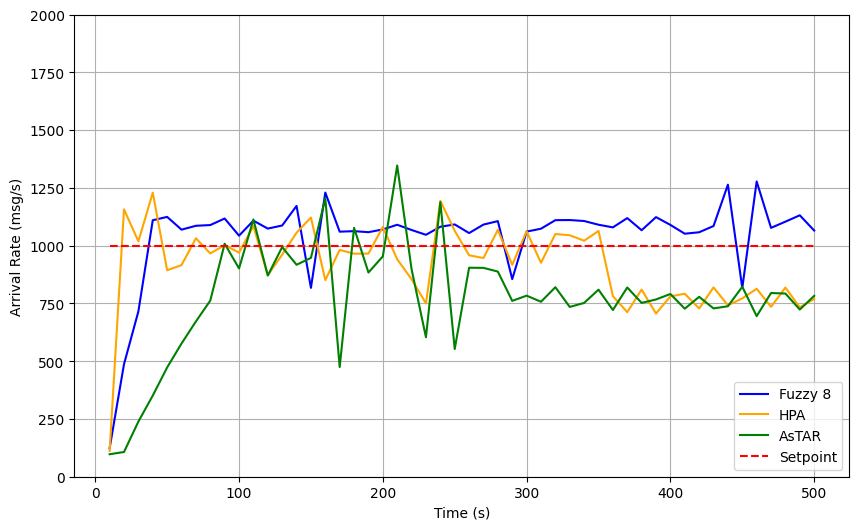

In [94]:
plot_arrival_rate_with_setpoint(df1=df1, df1_label='Fuzzy 8', df2=df2, df2_label='HPA', df3=df3, df3_label='AsTAR', output_pdf='bestFixed.pdf')

In [107]:
# Best variable
df1 = pd.read_csv('./variable_setpoint/fuzzy5_gaussmf_cod_variable_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df2 = pd.read_csv('./variable_setpoint/hpa_variable_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df3 = pd.read_csv('./variable_setpoint/astar_variable_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])

df1['TIME'] = [time_step * (i + 1) for i in range(len(df1))]
df2['TIME'] = [time_step * (i + 1) for i in range(len(df2))]
df3['TIME'] = [time_step * (i + 1) for i in range(len(df3))]

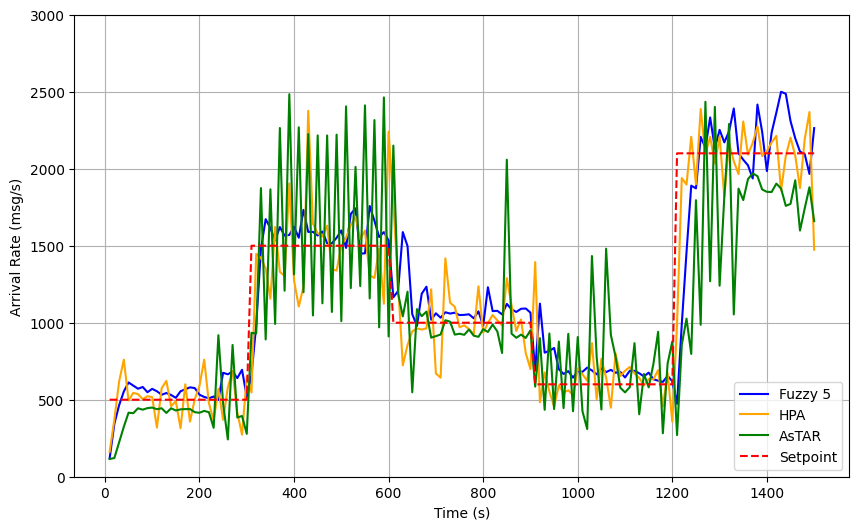

In [108]:
plot_arrival_rate_with_setpoint(df1=df1, df1_label='Fuzzy 5', df2=df2, df2_label='HPA', df3=df3, df3_label='AsTAR', output_pdf='bestVariable.pdf', maxY=3000)

In [98]:
# Worst fixed
df1 = pd.read_csv('./fixed_setpoint/fuzzy11_sigmoidmf_cod_fixed_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df2 = pd.read_csv('./fixed_setpoint/hpa_fixed_exp.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df3 = pd.read_csv('./fixed_setpoint/astar_fixed_exp.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])

df1['TIME'] = [time_step * (i + 1) for i in range(len(df1))]
df2['TIME'] = [time_step * (i + 1) for i in range(len(df2))]
df3['TIME'] = [time_step * (i + 1) for i in range(len(df3))]

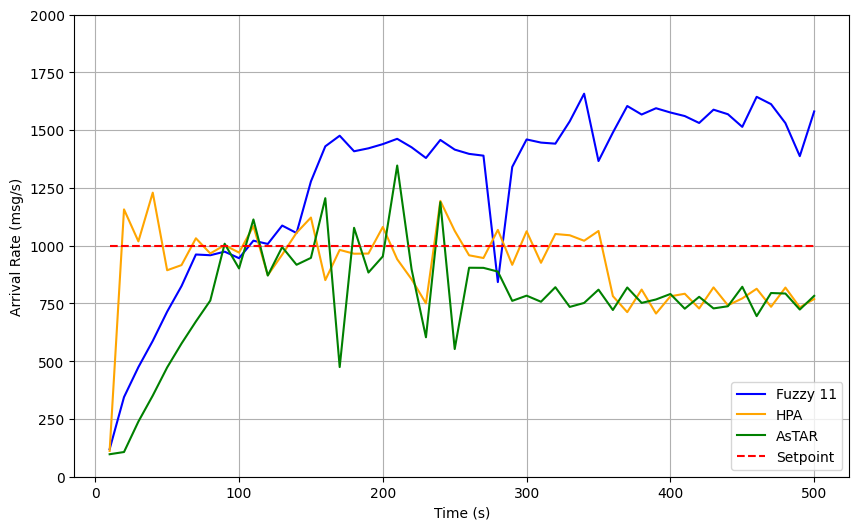

In [100]:
plot_arrival_rate_with_setpoint(df1=df1, df1_label='Fuzzy 11', df2=df2, df2_label='HPA', df3=df3, df3_label='AsTAR', output_pdf='worstFixed.pdf', maxY=2000)

In [104]:
# Worst variable
df1 = pd.read_csv('./variable_setpoint/fuzzy12_sigmoid_mom_variable_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df2 = pd.read_csv('./variable_setpoint/hpa_variable_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])
df3 = pd.read_csv('./variable_setpoint/astar_variable_exp2.csv', header=None, names=['PREFETCH_COUNT', 'ARRIVAL_RATE', 'SAMPLE_ID', 'SETPOINT'])

df1['TIME'] = [time_step * (i + 1) for i in range(len(df1))]
df2['TIME'] = [time_step * (i + 1) for i in range(len(df2))]
df3['TIME'] = [time_step * (i + 1) for i in range(len(df3))]

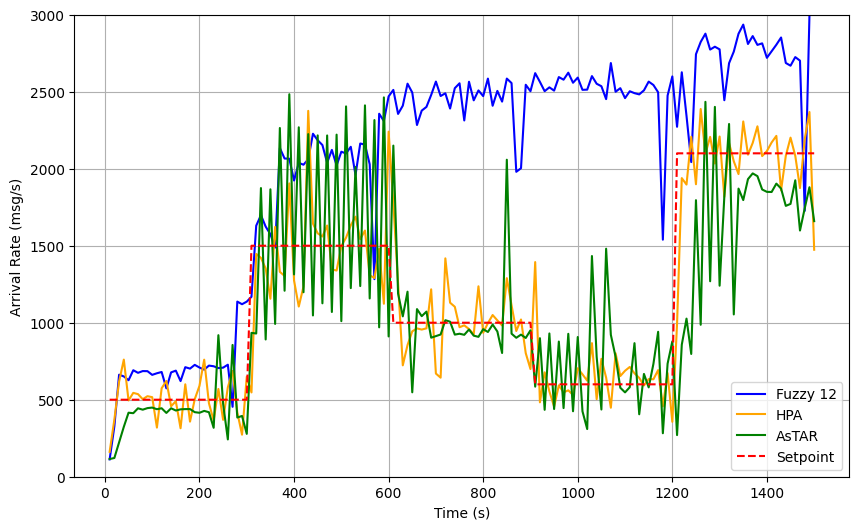

In [106]:
plot_arrival_rate_with_setpoint(df1=df1, df1_label='Fuzzy 12', df2=df2, df2_label='HPA', df3=df3, df3_label='AsTAR', output_pdf='wworstVariable.pdf', maxY=3000)